## Material Trade Centralities Analysis Lithium Key Resource Countries

This notebook explores the export volume and centrality metrics for the countries with the largest known lithum reserves.

### Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Preparation](##data-loading-and-preparation)
3. [Export Analysis](#export-analysis)
4. [Import Analaysis](#import-analysis)

---

## Data Loading and Preparation

In [1]:
from dataloader import DataLoader

loader = DataLoader(hs_code=282520)

_initialize_data took 39.1531 seconds


In [2]:
df = loader.get_data()

In [3]:
years = sorted(df['t'].unique())
yearly_graphs = loader.get_yearly_graphs(years)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

###############################################################################
# Analysis of export volume for selected countries
###############################################################################
def analyze_export_volume(df, countries=None):
    """
    Summarize and visualize (as a line chart) the export volume (column 'q')
    by year (column 't') for selected countries (column 'export_country').
    
    Parameters
    ----------
    df : pd.DataFrame
        Your DataFrame. Must have columns 't', 'export_country', 'q'.
    countries : list of str, optional
        The list of countries to filter on. If None, no filtering is done.
    
    Returns
    -------
    pd.DataFrame
        Pivoted DataFrame of export volumes, index = year, columns = country, values = sum of q.
    """
    if countries is not None:
        filtered_df = df[df['export_country'].isin(countries)].copy()
    else:
        filtered_df = df.copy()
    
    grouped = (
        filtered_df
        .groupby(['t', 'export_country'], as_index=False)['q']
        .sum()
    )
    
    pivot_df = grouped.pivot(index='t', columns='export_country', values='q')
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    ax = pivot_df.plot(ax=plt.gca(), marker='o', linewidth=2)

    for i, (start, end, label, color) in enumerate(crises):
        ax.axvspan(start, end, color=color, alpha=0.5, zorder=0)    

    plt.title("Export Volume Over Time", fontsize=14, fontweight='bold')
    plt.xlabel("Year (t)", fontsize=12)
    plt.ylabel("Export Volume (q)", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.legend(title='Exporter', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.yscale("log")
    
    x_values = pivot_df.index
    plt.xticks(ticks=x_values, labels=x_values, rotation=90)
    plt.show()
    
    return pivot_df


def analyze_import_volume(df, countries=None):
    """
    Summarize and visualize (as a line chart) the import volume (column 'q')
    by year (column 't') for selected countries (column 'import_country').

    Parameters
    ----------
    df : pd.DataFrame
        Your DataFrame. Must have columns 't', 'import_country', 'q'.
    countries : list of str, optional
        The list of countries to filter on (for importers). If None, no filtering is done.

    Returns
    -------
    pd.DataFrame
        A pivoted DataFrame of import volumes, index = year, columns = country,
        values = sum of 'q'.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    if countries is not None:
        filtered_df = df[df['import_country'].isin(countries)].copy()
    else:
        filtered_df = df.copy()

    grouped = (
        filtered_df
        .groupby(['t', 'import_country'], as_index=False)['q']
        .sum()
    )

    pivot_df = grouped.pivot(index='t', columns='import_country', values='q')

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = pivot_df.plot(ax=plt.gca(), marker='o', linewidth=2)
    
    for i, (start, end, label, color) in enumerate(crises):
        ax.axvspan(start, end, color=color, alpha=0.5, zorder=0)
    
    plt.title("Import Volume Over Time", fontsize=14, fontweight='bold')
    plt.xlabel("Year (t)", fontsize=12)
    plt.ylabel("Import Volume (q)", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.legend(title='Importer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.yscale("log")

    x_values = pivot_df.index
    plt.xticks(ticks=x_values, labels=x_values, rotation=90)

    plt.show()

    return pivot_df

In [23]:
###############################################################################
# Centrality analysis over time
###############################################################################

crises = [
    (2008, 2009, "World Economic Crisis", '#d3d3d3'),
    (2014, 2015, "Oil Price Crash", '#ffa500'),
    (2018, 2020, "Trump vs. China Trade War", '#90ee90'),
    (2020, 2022, "COVID Pandemic", '#add8e6'),
    (2020, 2022, "Chip Crisis", '#e6e6fa'),
    (2022, 2023, "Russian Attack on Ukraine", '#ff9999'),
]

def compute_func_over_time(yearly_graphs, func, weight, **kwargs):
    """
    Computes a chosen centrality function over a series of yearly graphs, 
    returning a DataFrame with columns: ['node', 'year', func.__name__].
    
    Parameters
    ----------
    yearly_graphs : dict
        A dict of the form {year: nx.Graph, ...}.
    func : function
        A networkx centrality function (nx.betweenness_centrality, nx.degree_centrality, etc.).
    weight : str or None
        The edge attribute to use as weight. If None, unweighted analysis is used.
    **kwargs : other parameters
        Additional arguments to pass to the centrality function (e.g. normalized=True).
    
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns = ['node', 'year', func.__name__].
    """
    import networkx as nx
    
    centrality_data = []

    for year, graph in yearly_graphs.items():
        if weight:
            edge_attribute_keys = {
                key for _, _, attr in graph.edges(data=True) for key in attr.keys()
            }
            if weight not in edge_attribute_keys:
                raise ValueError(f"Invalid weight attribute: {weight}")

            if func == nx.degree_centrality:
                total_weight = sum(1 for _, _, _ in graph.edges(data=True))
                metric_values = {
                    node: sum(1 for _, _, _ in graph.edges(node, data=True)) / total_weight
                    for node in graph.nodes()
                }
            else:
                metric_values = func(graph, weight=weight, **kwargs)
        else:
            metric_values = func(graph, **kwargs)

        for node, value in metric_values.items():
            centrality_data.append({'node': node, 'year': year, func.__name__: value})

    return pd.DataFrame(centrality_data)


def plot_func_trends_countries(
    centrality_df, 
    countries, 
    func_name, 
    comment, 
    export_path=".", 
    hs_label="lithium"
):
    """
    Plots the time-series trends of a centrality function ONLY for the 
    specified list of countries. Also overlays crisis periods as colored spans.

    This uses figsize=(6, 5) to match your desired dimensions.
    
    Parameters
    ----------
    centrality_df : pd.DataFrame
        DataFrame with columns: ['node', 'year', <func_name>].
    countries : list of str
        The countries you want to highlight/plot.
    func_name : str
        The column name in centrality_df that holds the centrality values.
    comment : str
        Extra text for figure file naming.
    export_path : str
        Path to directory where the figure should be saved.
    hs_label : str
        Label for product/material, used in filename.
    """
    name = " ".join(func_name.split("_")).title()
    
    filtered_df = centrality_df[centrality_df['node'].isin(countries)].copy()
    
    if filtered_df.empty:
        print("Warning: None of the selected countries are found in the centrality DataFrame.")
        return

    pivot_df = filtered_df.pivot(index='year', columns='node', values=func_name)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    pivot_df.plot(ax=ax, marker='o', legend=False)
    
    overlapping_colors = ['#d3d3d3', '#ffdd44', '#90ee90', '#add8e6', '#e6e6fa', '#ff9999']
    for i, (start, end, label, color) in enumerate(crises):
        ax.axvspan(start, end, color=overlapping_colors[i], alpha=0.5, zorder=0)

    country_handles = [
        plt.Line2D([0], [0], color=ax.lines[i].get_color(), lw=2, marker='o', label=node)
        for i, node in enumerate(pivot_df.columns)
    ]
    
    crisis_handles = [
        plt.Line2D([0], [0], color=overlapping_colors[i], lw=8, alpha=0.5, label=label)
        for i, (_, _, label, _) in enumerate(crises)
    ]

    fig.legend(
        handles=country_handles + crisis_handles,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=2,
        fontsize="small",
        title="Legends"
    )

    plt.title(f'{name} Trends Over Time')
    plt.xlabel('Year')
    plt.xticks(ticks=sorted(filtered_df['year'].unique()), rotation=90)
    plt.ylabel(name)
    plt.grid(color="white")
    plt.tight_layout()

    filename = os.path.join(export_path, f"{hs_label}_{func_name}_{comment}.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight", format="png")
    plt.show()

def process_visualization_countries(
    yearly_graphs, 
    func, 
    countries, 
    weight="inverse_weight", 
    comment="", 
    export_path=".", 
    hs_label="lithium"
):
    """
    Convenience function:
      1) Compute the chosen centrality for each year,
      2) Plot only the specified list of countries (no top N logic).
    """
    centrality_df = compute_func_over_time(yearly_graphs, func, weight=weight)
    plot_func_trends_countries(
        centrality_df=centrality_df,
        countries=countries,
        func_name=func.__name__,
        comment=comment,
        export_path=export_path,
        hs_label=hs_label
    )

## Export Analysis

In [24]:
# Countries with largest known reserves
countries_to_analyze = [
    "Chile", 
    "Australia", 
    "Argentina", 
    "China", 
    "United States of America", 
    "Canada", 
    "Brazil", 
    "Zimbabwe", 
    "Portugal"
]

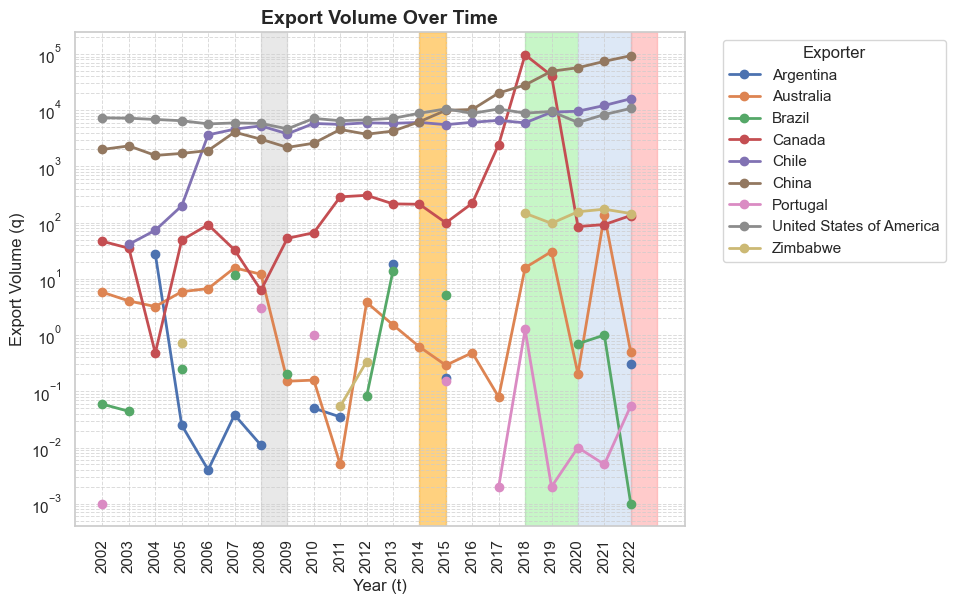

In [25]:
pivot_export_volumes = analyze_export_volume(df, countries_to_analyze)

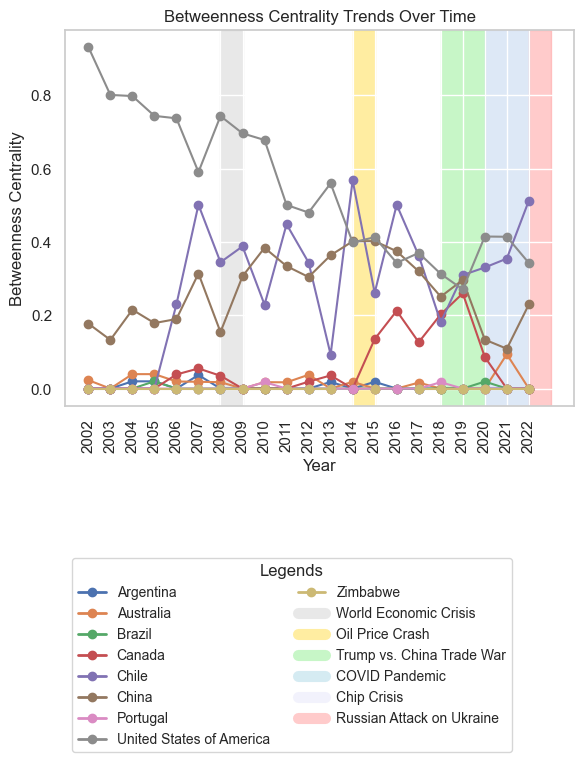

In [26]:
func = nx.betweenness_centrality
process_visualization_countries(
    yearly_graphs=yearly_graphs,
    func=func,
    countries=countries_to_analyze,
    weight="inverse_weight",
)

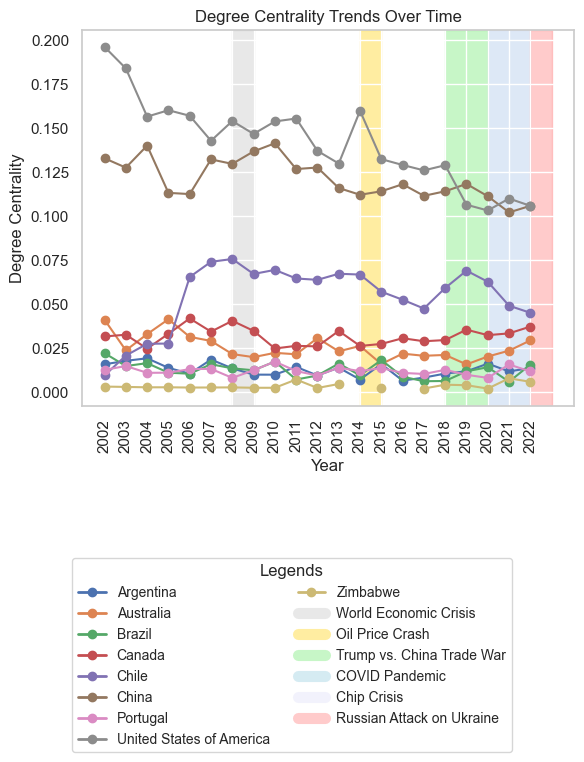

In [27]:
func = nx.degree_centrality
process_visualization_countries(
    yearly_graphs=yearly_graphs,
    func=func,
    countries=countries_to_analyze,
    weight="inverse_weight",
)

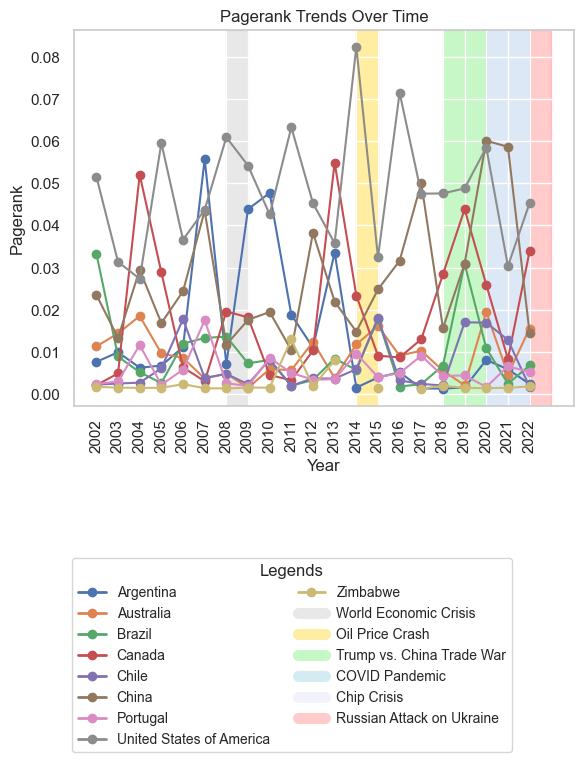

In [28]:
func = nx.pagerank
process_visualization_countries(
    yearly_graphs=yearly_graphs,
    func=func,
    countries=countries_to_analyze,
    weight="inverse_weight",
)

## Import Analysis

In [29]:
# Top Importers
countries_to_analyze = [
    "South Korea", 
    "Germany", 
    "China", 
    "Belgium", 
    "Japan", 
]

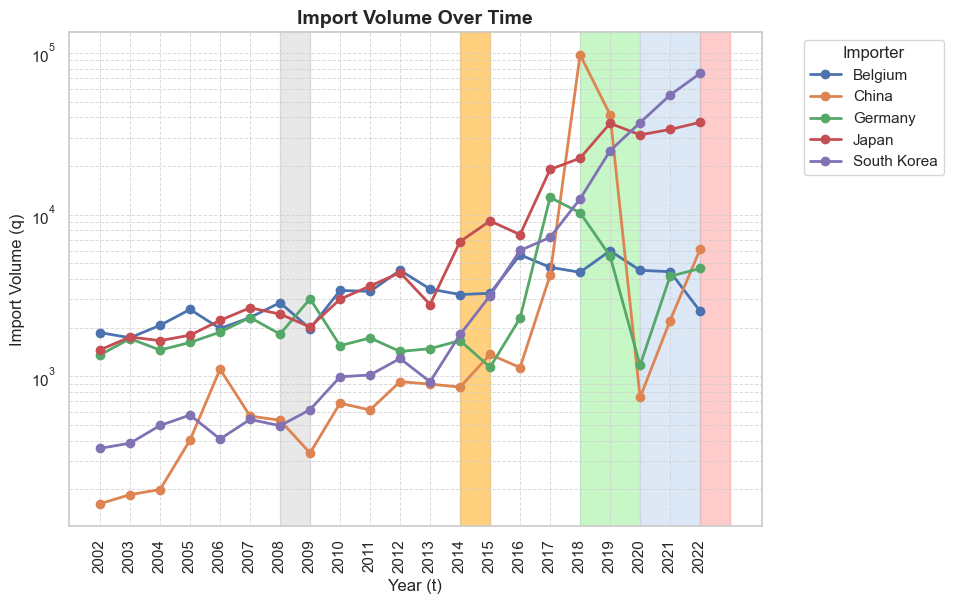

In [30]:
pivot_import_volume = analyze_import_volume(df, countries_to_analyze)

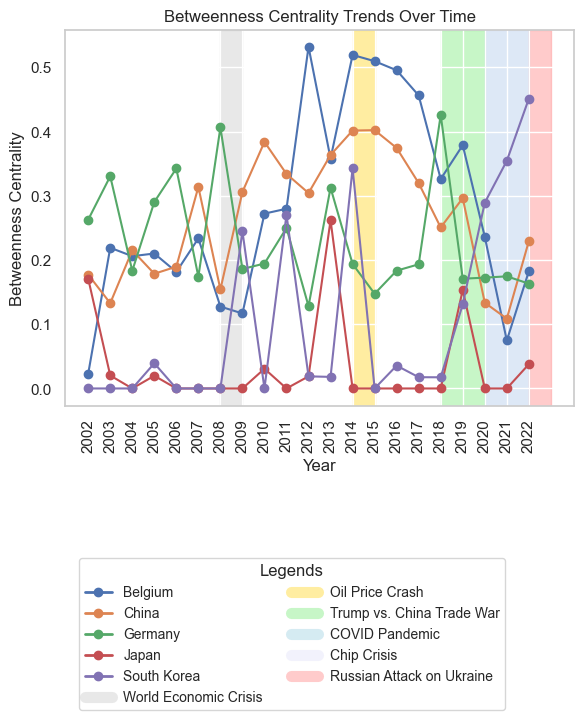

In [31]:
func = nx.betweenness_centrality
process_visualization_countries(
    yearly_graphs=yearly_graphs,
    func=func,
    countries=countries_to_analyze,
    weight="inverse_weight",
)

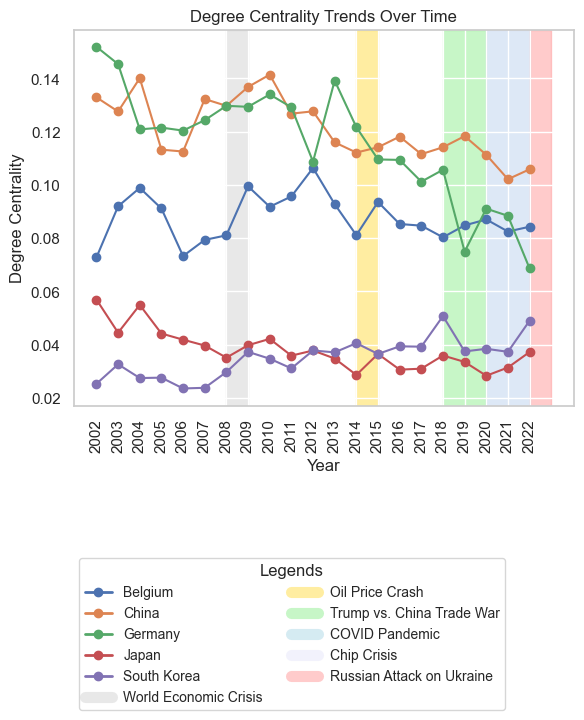

In [32]:
func = nx.degree_centrality
process_visualization_countries(
    yearly_graphs=yearly_graphs,
    func=func,
    countries=countries_to_analyze,
    weight="inverse_weight",
)

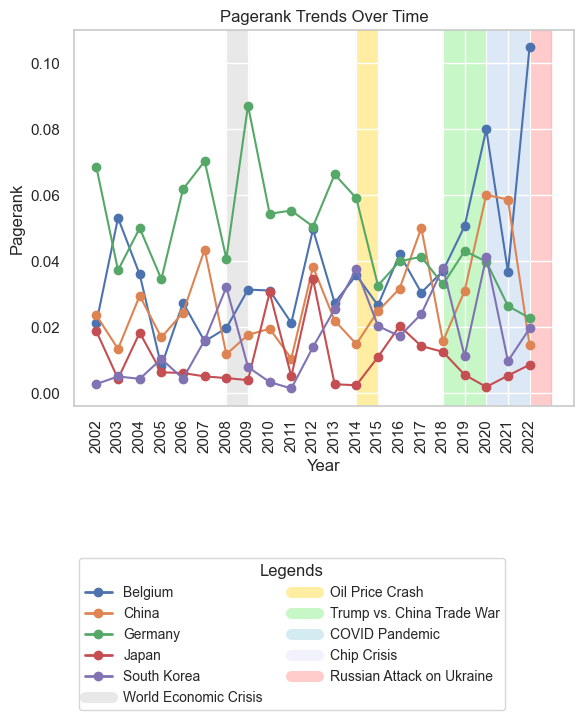

In [33]:
func = nx.pagerank
process_visualization_countries(
    yearly_graphs=yearly_graphs,
    func=func,
    countries=countries_to_analyze,
    weight="inverse_weight",
)